# Model training
> Examples of how to train machine learning model to perform the pointwise characterization of single-trajectories.

In this tutorial, we show how to train machine learning models to predict diffusion properties of interest, such as the diffusion coefficient $D$, the anomalous diffusion exponent $\alpha$ or the diffusion model that best describes the observation (as in the [AnDi Challenge](https://www.nature.com/articles/s41467-021-26320-w)).

The methods presented here make extensive use of our [STEP library](https://borjarequena.github.io/step/). Follow the steps thoroughly to replicate the results of [our paper](https://arxiv.org/abs/2302.00410).

In [ ]:
#| hide
from step.data import *
from step.utils import *
from step.models import *
from fastai.vision.all import * 

# Reproducing experimental conditions

When training machine learning models to characterize diffusion processes, we need to keep in mind that these should be robust to the adversities related with the typical experimental conditions.

A key factor to consider, is the localization precision of the experiment or localization noise. Here, we simulate it as white noise with standard deviation $\sigma_{\text{noise}}$ that we add to the trajectories. This also acts as a form of data augmentation and helps our model generalize better.

In [ ]:
class LocalizationNoise(ItemTransform):
    "Add localization noise to the trajectories."
    def __init__(self, noise_lvls): self.noise_lvls = tensor(noise_lvls)
    def encodes(self, sample):
        x, y = sample
        idx = torch.randint(self.noise_lvls.shape[0], (1,))
        noise = self.noise_lvls[idx]
        noisy_x = x + 10**(noise)*torch.randn_like(x)
        return noisy_x - noisy_x[0], y

With `LocalizationNoise`, we add noise to every trajectory in a training batch. It takes `noise_lvls` as input, which is a list of the different $\sigma_{\text{noise}}$ to consider in $\log_{10}$ scale. This way, we can choose to randomly add different levels of noise to each trajectory.   

# Brownian motion

Brownian motion, or normal diffusion, is characterized by a mean squared displacement $\langle x^2\rangle=2dDt$, where $d$ denotes the dimension, $D$ is the diffusion coefficient and $t$ is the time. Thus, the goal is to find $D$ given the observations.

## Generate the data

In order to train our models, we need to generate a data set. As we explain in the [data docs](https://borjarequena.github.io/step/source/data.html#datasets-with-variable-number-of-change-points), our trajectories contain different numbers of changepoints. To do so, we generate separate data sets with a fixed number of change points and combine them together.

We have found that training our models with 2 to 5 segments (1 to 4 changepoints) is more than enough to generalize well to trajectories with an abritrary number of segments.

::: {.callout-note}
Skip this section if you already have a data set to train!
:::

In [ ]:
n_per_set = 12000
max_t = 200
dim = 2
Ds = np.logspace(-3, 3, 1000) 
cps = [1, 2, 3, 4]
ds_fun = partial(create_bm_segmentation_dataset,
                 max_t=max_t, dim=dim, Ds=Ds, save=False)

In [ ]:
datasets = [ds_fun(n_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)

n_change = f"{min(cps)}_to_{max(cps)}"
save_path = DATA_PATH/get_bmds_fname(n_change + "_train", max_t, dim)
dataset.to_pickle(save_path)

## Train the model

We train our models using the [fastai library](https://docs.fast.ai/) to handle the training loop. To do so, we combine the essential blocks of any training loop:

- A model to train
- A data loader
- A loss function
- An optimization algorithm (we use the default Adam)

Into a [`Learner`](https://docs.fast.ai/learner.html#learner) object. We can tweak all sorts of parameters and add, for example, data agumentation transforms, such as the `LocalizationNoise` we have defined above.

::: {.callout-note}
For anyone starting with machine learning, we recommend checking the [fastai courses](fast.ai) and their [book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), which is also available in [open source](https://github.com/fastai/fastbook).
:::

We start by creating the data loaders that will take the data from above. Since we are working with Brownian motion trajectories and we wish to find the diffusion coefficient, we need to set `bm=True` and `target=y_exp`. `y_exp` is the option for continuous targets, do not use `y_mod` as it expects integer values. We know it's not the cleanest API for brownian motion :(
    
Additionally, rather than predicting the actual value of the diffusion coefficient, we will work with its logarithm, so we set `tfm_y=torch.log10`. This allows us to mantain a constant relative error across all the orders of magnitude. Finally, we set the device to be the `default_device`, which is the first GPU, in case there is one, or the CPU.

In [ ]:
dim = 2
dls = get_segmentation_dls(target='y_exp', dim=dim,
                           n_change='1_to_4_train', tfm_y=torch.log10, bm=True)
dls.device = default_device()

We can add the localization noise transform to our data. We will leave some noiseless trajectories ($\log_{10}\sigma_{\text{noise}}=-\infty$) and then take noise amplitudes from $10^{-6}$ to $10^{1}$.

In [ ]:
noise_levels = torch.cat([-tensor([float('inf')]), torch.linspace(-6, 1, 8)])
dls.add_tfms(LocalizationNoise(noise_levels), 'after_item')

For the machine learning model, we have found that our `XResAtnn` model works the best and trains rather fast.

In [ ]:
model = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-3.1, 5.1))
model.to(default_device())

Finally, we put all together in a `Leaner`. We will use the mean absolute error loss, or $L_1$ loss and the Adam optimizer (default option in the learner).

In [ ]:
learn = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

A rather handy functionality of the learner is the `lr_find` method. This function trains the model for a few mini-batches changing the learning rate. Then, we can visualize the loss and determine the regions where the model is learning, where the learning rate is too low and where it diverges.

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=1.3182567499825382e-06)

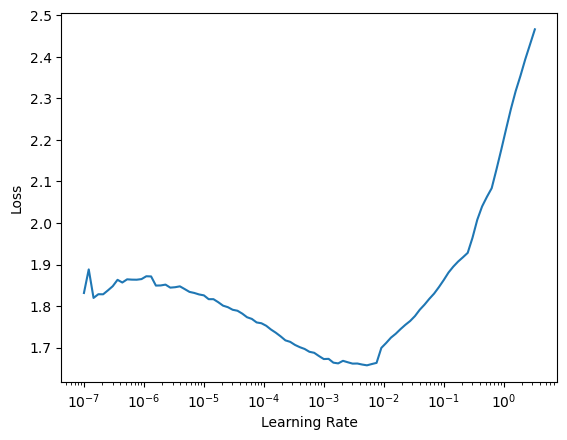

In [ ]:
learn.lr_find()

This is a typical shape where we have a regime where the model is not learning, followed by a fast-learning regime (slope downhill) and then a divergence region. We usually take a learning rate that is about 10x below the valley.

Then we train with `fit_one_cycle`, which follows the [one-cycle policy](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11006/1100612/Super-convergence--very-fast-training-of-neural-networks-using/10.1117/12.2520589.short). We typically train with a few epochs and, if we see the model is still learning and not overfitting, we resume the training. 

In [ ]:
learn.fit_one_cycle(30, lr_max=2e-4)

Finally, we can save the model.

In [ ]:
learn.save(f'xresattn_bm_{dim}d_1_to_4_cp')

# Anomalous diffusion

In complex environments, such as cells, we find that the diffusive behaviour of many particles deviates from Brownian motion. This is typically characterized by effective models whose mean squared displacement scales as a power-law with time $\langle x^2\rangle\propto t^\alpha$, as opposed to the linear dependence in Brownian motion. We could see normal diffusion as the particular case of $\alpha=1$.

Here, we consider the same five anomalous diffusion models as in the [AnDi challenge](https://www.nature.com/articles/s41467-021-26320-w):

 - Annealed transit time (ATTM) with $\alpha\in\left[0.05, 1\right]$.
 - Continuous time random walk (CTRW) with $\alpha\in\left[0.05, 1\right]$.
 - Fractional Brownian motion (FBM) with $\alpha\in\left[0.05, 1.95\right]$.
 - Lévy Walk (LW) with $\alpha\in\left[1.05, 2\right]$.
 - Scaled Brownian motion (SBM) with $\alpha\in\left[0.05, 2\right]$.

 and we consider intervals of 0.05 within the specified ranges of $\alpha$.

::: {.callout-note}
Some of these anomalous diffusion models are "Brownian motion with extra steps", usually due to the interaction between the particles and their environments. In [our work](https://arxiv.org/abs/2302.00410), we show how to study anomalous diffusion directly from the pointwise characterization of normal diffusion taking ATTM and SBM trajectories as examples.
:::

Hence, when we study anomalous diffusion, we can consider two tasks: predicting $\alpha$, or the model that best describes the observation.

## Generate the data

We generate the data in a very similar way as in the Brownian motion case. We combine data sets with anomalous diffusion trajectories that have different numbers of segments. Since there are two variables: $\alpha$ and anomalous diffusion model, we consider a new segment whenever, at least one, of the two quantities varies.

::: {.callout-note}
Skip this section if you already have a data set to train!
:::

In this training data set, we will consider all the diffusion models with all their available exponents. Furthermore, we will not add any localization noise to the raw data, as we will use our `LocalizationNoise` data augmentation during training. 

In [ ]:
n_per_set = 12500
max_t = 200
dim = 2 
cps = [1, 2, 3, 4]
ds_fun = partial(create_andi_segmentation_dataset,
                 max_t=max_t, dim=dim, noise=[0.], save=False)

In [ ]:
datasets = [ds_fun(n_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)

n_change = f"{min(cps)}_to_{max(cps)}"
save_path = DATA_PATH/get_andids_fname(n_change + "_train", max_t, dim)
dataset.to_pickle(save_path)

::: {.callout-note}
You may see some warnings while the data set is createad, but don't panic, they're harmless.
:::

## Train the models

We will show two examples: a regression task for the anomalous diffusion exponent and a classification task for the anomalous diffusion model. The whole pipeline is very similar to the case of Brownian motion: load data loaders, model and cost function in a learner and train.

### Anomalous diffusion exponent

The task here is to predict $\alpha$. Thus, we will set `target=y_exp` in the data loader. 

In [ ]:
dim = 2
dls = get_segmentation_dls(dim=dim, target='y_exp', n_change='1_to_4_train')
dls.device = default_device()

In this case, we add localization noise with $\sigma_{\text{noise}}\in\left[10^{-4}, 10^0\right]$ and we leave some noiseless trajectories.

In [ ]:
noise_levels = torch.cat([-tensor([float('inf')]), torch.linspace(-4, 0, 11)])
dls.add_tfms(LocalizationNoise(noise_levels), 'after_item')

Then, we can create our model and combine all together in a `Learner`.

In [ ]:
model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn_exp = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

Just as before, we can look for a suitable learning rate and train the model.

In [ ]:
learn_exp.lr_find()

In [ ]:
learn_exp.fit_one_cycle(20, lr_max=2e-4)

Finally, we can save the trained model.

In [ ]:
learn_exp.save(f'xresattn_exp_{dim}d_1_to_4_cp')

### Anomalous diffusion model

To know what is the anomalous diffusion model that best describes the observations, we need to perform a pointwise classification task. We have 5 possible classes corresponding to each of the models.

::: {.callout-note}
In [our paper](https://arxiv.org/abs/2302.00410), we do not show any example of this task.
:::

In this case, we do not need to set `target=y_mod`, as it is the default option for our data loaders.

In [ ]:
dim = 2
dls = get_segmentation_dls(dim=dim, n_change='1_to_4_train')
dls.device = default_device()
noise_levels = torch.cat([-tensor([float('inf')]), torch.linspace(-4, 0, 11)])
dls.add_tfms(LocalizationNoise(noise_levels), 'after_item')

Creating our model, we do not need to specify `n_class=5` because it's the default option.

In [ ]:
model = XResAttn(dim, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 p=0.5, dropout=0.6, linear_layers=[])
model.to(default_device())

In the previous cases, the loss function was a direct indicative of the metric that we cared about. However, in this case, it is convenient to track additional metrics, such as the [F1 score](https://en.wikipedia.org/wiki/F-score).

As loss function, we use the cross entropy loss with label smoothing, a very sucessful regularization technique.

In [ ]:

metrics = [F1Score(average='micro')]
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(),
                metrics=metrics, model_dir=MODEL_PATH)

Just as before, we can look for a suitable learning rate.

In [ ]:
learn.lr_find()

Train our model.

In [ ]:
learn.fit_one_cycle(20, lr_max=2e-3)

And save it!

In [ ]:
learn.save(f'xresattn_class_{dim}d_1_to_4cp')